# Recuperando referências a partir de dados não-estruturados


<div style="text-align: right"> 
<h3>EScience - PPG IC/UFF 2017.1</h3>

<h4>Daniel Junior, Kid Valeriano</h4>

</div>


## Relembrando...
O projeto tem como base o artigo <strong>Provenance as data mining: Combining file system metadata with content analysis</strong>.
</hr>
<li>A ideia é utilizar técnicas de Mineração de Dados para recuperar possíveis referências de um dado não-estruturados.</li>
<li>Os dados não-estruturados utilizados como dados de entrada para o projeto são arquivos textos.</li>

## Arquitetura
<div width="100%" height="100%">
    <img src="images/Arquitetura2.png" height="400" width="800" style="margin: 0 auto;"/>
</div>

## Projeto
<ul>
    <li>Linguagem Python</li>
    <li>Biblioteca Sci-kit Learn</li>
    <li>Os dados usados no experimento são do repositório <strong><a href="https://l.facebook.com/l.php?u=http%3A%2F%2F137.207.234.78%2Fsearch%2Fdetail%2F&h=ATMRd4R-lyI7h1CWdhxvn6UWFuIQ6Sk5lh5mt_Yl5P4cZtgMLg2Eab3JBX_fKeG0-K69PJBwnMqh8BrtHvD__C71t0gmJg-NTkGuLNtxIehOx2CwfwQx_44sEEALKLVSY6y_fg">CiteSeerX</a></strong></li>
</ul>

## Projeto

<!--Os passos a serem seguidos são:-->
<ol>
    <li>Dado um diretório que contenha a referências em arquivos .txt, devo ser capaz de recuperar o conteúdo de cada arquivo.</li>
    <li>Representar o conteúdo do arquivo de uma forma que seja possível aplicar algoritmos de Clustering.</li>
    <li>Executar o algoritmo para criar os clusters.</li>
    <li>Para cada arquivo em um cluster, recuperar os metados relativos ao dados de modificação do arquivo.</li>
    <li>Com os metadados em mãos, exportar para o PROV-Model, fazendo o armazenamento em um banco relacional (SQLite).</li>
    <li>Ser capaz de receber um arquivo de entrada e retornar uma representação gráfica da proveniência do mesmo.</li>
</ol>


In [13]:
import os, time
from stat import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

CLUSTERS_NUMBER = 2

### Passo 1: Carregar os dados

In [14]:
PATH = "data"
filenames = []
docs = []
for path, dirs, files in os.walk(PATH):
    for filename in files:
        fullpath = os.path.join(path, filename)
        with open(fullpath, 'r') as f:
            data = f.read()
            filenames.append(fullpath)
            docs.append(data)        
print(filenames[:10])

['data/d1/doc567.txt', 'data/d1/doc505.txt', 'data/d1/doc483.txt', 'data/d1/doc498.txt', 'data/d1/doc462.txt', 'data/d1/doc570.txt', 'data/d1/doc474.txt', 'data/d1/doc548.txt', 'data/d1/doc546.txt', 'data/d1/doc539.txt']


In [15]:
train_data = shuffle(docs, random_state=42)[int(len(docs)*0.2):]
test_data = shuffle(docs, random_state=42)[:int(len(docs)*0.2)]
#print(train_data[:1])
train_filenames = shuffle(filenames, random_state=42)[int(len(docs)*0.2):]
test_filenames = shuffle(filenames, random_state=42)[:int(len(docs)*0.2)]


### Passo 2: Representação vetorial dos dados


<div width="100%" height="100%">
    <img src="images/tfidf.png" style="margin: 0 auto;" width="800px" heigth="600px"/>
</div>

In [16]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_features=200000,)
tfidf_matrix = tfidf_vectorizer.fit_transform(train_data)
print("Dimensões da matriz:")
print(tfidf_matrix.todense().shape)

Dimensões da matriz:
(929, 19371)


### Para uma melhor eficiência constrói-se um vocabulário com as raízes das palavras, conseguindo diminuir o tamanho do nosso vetor de frequências.

In [17]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
import nltk
import re
stemmer = SnowballStemmer("english")

In [18]:
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [19]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_features=200000,tokenizer=tokenize_and_stem,)
tfidf_matrix = tfidf_vectorizer.fit_transform(train_data)
print("Dimensões da matriz:")
print(tfidf_matrix.todense().shape)

Dimensões da matriz:
(929, 15007)


### Passo 3: Executar algoritmo de clustering

In [20]:
km = KMeans(n_clusters=CLUSTERS_NUMBER, init='k-means++', max_iter=100, n_init=1,verbose=False)
km.fit(tfidf_matrix.todense())
print(km.labels_[:20])

[1 0 0 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 1 1]


## Visualização dos Clusters em 2 dimensões usando PCA 

In [22]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])        
X = pipeline.fit_transform(train_data).todense()
rgb = np.random.random((2, 3))
pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c=rgb)
#plt.show()   

km2 = KMeans(n_clusters=CLUSTERS_NUMBER, init='k-means++', max_iter=100, n_init=1,verbose=False)
km2.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=2, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=False)

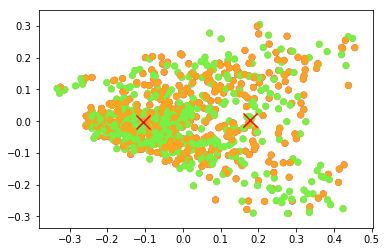

In [23]:
centers2D = pca.transform(km2.cluster_centers_)

plt.scatter(centers2D[:,0], centers2D[:,1], 
            marker='x', s=200, linewidths=3, c='r')
plt.show() 
# https://stackoverflow.com/questions/28160335/plot-a-document-tfidf-2d-graph

### Passo 4: Recuperar os metadados dos arquivos de cada cluster

In [25]:
clusters_predict = km.predict(tfidf_vectorizer.transform(test_data))
cluster_0_idx =  [i for i, x in enumerate(clusters_predict) if x == 0]
filenames_cluster_0 = [test_filenames[x] for x in cluster_0_idx ]

for filename in filenames_cluster_0[:1]:
    st = os.stat(filename)
    print("filename:", filename)
    print("file modified:", time.asctime(time.localtime(st[ST_CTIME])))
    print("file size:", st[ST_SIZE])
    

filename: data/d2/doc646.txt
file modified: Tue May 23 20:16:38 2017
file size: 703


In [ ]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
for i in range(2):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()
    
#km.predict(tfidf_vectorizer.transform(test_data.data).todense())

In [ ]:
from IPython.core.display import HTML
from urllib.request import urlopen
HTML(urlopen('https://raw.githubusercontent.com/lmarti/jupyter_custom/master/custom.include').read().decode('utf-8'))

In [1]:
import xml.etree.ElementTree as ET
tree = ET.parse('docEjemplo.xml')
root = tree.getroot()
titles=[]
for cts in root.iter('citation'):
    title = cts.find('title').text
    titles.append(title)
titles[:4]

['T.: Coping with temporal constraints in multimedia presentation planning',
 'T.: Generating multimedia presentations for RoboCup soccer games. In: RoboCup ’97: Robot Soccer World Cup I, ed by Kitano',
 'Employing AI methods to control the behavior of animated interface agents',
 'S.: The automated design of believable dialogues for animated presentation teams. In: Embodied Conversational Agents, ed by']